In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


In [2]:
import pandas as pd

In [3]:
# Set batch size for training
BATCH_SIZE = 16

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 20

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 0.2

In [4]:
data = np.load("/kaggle/input/an2dl-challenge-2/mars_for_students_V1.npz")

In [5]:
X = np.load('/kaggle/input/datasetcleaned/X.npy')
y = np.load('/kaggle/input/datasetcleaned/y.npy')
X_test = data["test_set"]

In [6]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
X_train, X_val,y_train, y_val = train_test_split(
    X, y, test_size=SPLITS_SIZE, random_state=seed
)
X_train = (X_train[..., np.newaxis]) / 255.0
X_val = (X_val[..., np.newaxis]) / 255.0
X_test = (X_test[..., np.newaxis])/ 255.0
print("Data splitted!")
print("X_train:",X_train.shape,"y_train:",y_train.shape,"X_val:",X_val.shape,"y_val:",y_val.shape)
print(X_test.shape)

Splitting data...
Data splitted!
X_train: (2004, 64, 128, 1) y_train: (2004, 64, 128) X_val: (501, 64, 128, 1) y_val: (501, 64, 128)
(10022, 64, 128, 1)


In [7]:
print(X_test.shape)

(10022, 64, 128, 1)


In [8]:
cw =compute_class_weight(class_weight="balanced",classes=np.unique(y_train),y=y_train.flatten())
print(cw)
cw[0] = 0.0
print(cw)

[  0.8249854    0.59350279   0.83660996   1.10969433 153.93846875]
[  0.           0.59350279   0.83660996   1.10969433 153.93846875]


In [9]:
 category_map = {
        0: 0,  # unlabelled
        1: 1,  # static
        2: 2,  # ground
        3: 3,  # road
        4: 4}  # sidewalk
NUM_CLASSES = len(set(category_map.values()))
print(f"Number of original categories: {len(category_map)}")
print(f"Number of classes after mapping: {NUM_CLASSES}")

Number of original categories: 5
Number of classes after mapping: 5


In [10]:
def load_single_image(image, label, input_size=(64, 128)):
    
    # Read and preprocess the image
    image = tf.cast(image, tf.float32)

    # Read and preprocess the label
    label = tf.cast(label, tf.int32)

    return image, label

In [11]:
def apply_category_mapping(label):

    #Apply category mapping to labels.

    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [12]:
@tf.function
def random_flip(image, label, seed=None):
    #Consistent random horizontal flip.
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [13]:
#Create a memory-efficient TensorFlow dataset.
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [14]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (16, 64, 128, 1)
Labels shape: (16, 64, 128)
Labels dtype: <dtype: 'int32'>


In [15]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, ReLU, Add
)
from tensorflow.keras.models import Model

# A bridge layer for the U-Net bottleneck.
def residual_bridge_layer(inputs, filters):
    # Main path
    x = Conv2D(filters, kernel_size=3, padding="same", activation=None)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=3, padding="same", activation=None)(x)
    x = BatchNormalization()(x)

    # Residual connection
    residual = Conv2D(filters, kernel_size=1, padding="same", activation=None)(inputs)
    x = Add()([x, residual])
    x = ReLU()(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    x = conv_block(x, num_filters)

    p = tfkl.MaxPool2D((2, 2))(x)
    return x, p



def conv_block(x, num_filters, act=True,iter=1):
    for i in range(iter):
        x = tfkl.Conv2D(num_filters, kernel_size=3, padding="same")(x)

        if act == True:
            x = tfkl.BatchNormalization()(x)
            x = tfkl.Activation("relu")(x)

    return x

# U-Net 3 Model
def unet3_model(input_shape=(64, 128, 1), num_classes=5,deep_sup = True):
    inputs = Input(input_shape)
    print(inputs.shape)
    # Encoder
    skip1, pool1 = encoder_block(inputs, 64)
    print("skip1: ",skip1.shape," pool1: ",pool1.shape)

    skip2, pool2 = encoder_block(pool1, 128)
    print("skip2: ",skip2.shape," pool2: ",pool2.shape)
    #
    skip3, pool3 = encoder_block(pool2, 256)
    print("skip3: ",skip3.shape," pool3: ",pool3.shape)
    print("-----"*10)
    bridge = residual_bridge_layer(pool3, 512)
    print("bridge: ",bridge.shape)
    print("-----"*10)


    # Decoder 3 -------------------------------------------------------------
    skip1_d3 = tfkl.MaxPool2D((4, 4))(skip1)
    print("Before skip1_d3: ",skip1_d3.shape)
    skip1_d3 = conv_block(skip1_d3, 64)
    print("After skip1_d3: ",skip1_d3.shape,"\n")

    skip2_d3 = tfkl.MaxPool2D((2, 2))(skip2)
    print("Before skip2_d3: ",skip2_d3.shape)
    skip2_d3 = conv_block(skip2_d3, 64)
    print("After skip2_d3: ",skip2_d3.shape,"\n")

    skip3_d3 = conv_block(skip3, 64)
    print("After skip3_d3: ",skip3_d3.shape)

    bridge_d3 = tfkl.UpSampling2D((2, 2), interpolation="bilinear")(bridge)
    bridge_d3 = conv_block(bridge_d3, 64)
    print("After bridge_d3: ",bridge_d3.shape)

    decoder3 = tfkl.Add()([skip1_d3,skip2_d3,skip3_d3,bridge_d3])
    decoder3 = conv_block(decoder3, 64*4)
    print("decoder3: ",decoder3.shape)
    print("------"*10)

    #Decoder 2 -------------------------------------------------------------
    skip1_d2 = tfkl.MaxPool2D((2, 2))(skip1)
    print("Before skip1_d2: ",skip1_d2.shape)
    skip1_d2 = conv_block(skip1_d2, 64)
    print("After skip1_d2: ",skip1_d2.shape,"\n")

    skip2_d2 = conv_block(skip2, 64)
    print("After skip2_d2: ",skip2_d2.shape)

    bridge_d2 = tfkl.UpSampling2D((4, 4), interpolation="bilinear")(bridge)
    bridge_d2 = conv_block(bridge_d2, 64)
    print("After bridge_d3: ",bridge_d2.shape)

    d3_d2 = tfkl.UpSampling2D((2, 2), interpolation="bilinear")(decoder3)
    d3_d2 = conv_block(d3_d2, 64)
    print("After bridge_d3: ",d3_d2.shape)

    #decoder2 = decoder_block(decoder3, [skip1_d2,skip2_d2], 64)
    decoder2 = tfkl.Add()([skip1_d2,skip2_d2,bridge_d2,d3_d2])
    decoder2 = conv_block(decoder2, 64*4)
    print("decoder2: ",decoder2.shape)
    print("-----"*10)

    #Decoder 1
    skip1_d1 = conv_block(skip1, 64)
    print("After skip1_d3: ",skip1_d1.shape)

    bridge_d1 = tfkl.UpSampling2D((8, 8), interpolation="bilinear")(bridge)
    bridge_d1 = conv_block(bridge_d1, 64)
    print("After bridge_d1: ",bridge_d1.shape)

    d3_d1 = tfkl.UpSampling2D((4, 4), interpolation="bilinear")(decoder3)
    d3_d1 = conv_block(d3_d1, 64)
    print("After bridge_d3: ",d3_d1.shape)

    d2_d1 = tfkl.UpSampling2D((2, 2), interpolation="bilinear")(decoder2)
    d2_d1 = conv_block(d2_d1, 64)
    print("After d3_d2: ",d2_d1.shape)

    #decoder1 = decoder_block(decoder2, [skip1_d3], 64)
    decoder1 = tfkl.Add()([skip1_d1,bridge_d1,d3_d1,d2_d1])
    decoder1 = conv_block(decoder1, 64*4)
    print("decoder1: ",decoder1.shape)
    print("-----"*10)

    # Output layer
    if deep_sup == True:
        y1 = tfkl.Conv2D(num_classes, kernel_size=3, padding="same")(decoder1)
        y1 = tfkl.Activation("softmax",name='y1')(y1)

        y2 = tfkl.Conv2D(num_classes, kernel_size=3, padding="same")(decoder2)
        y2 = tfkl.UpSampling2D((2, 2), interpolation="bilinear")(y2)
        y2 = tfkl.Activation("softmax",name='y2')(y2)

        y3 = tfkl.Conv2D(num_classes, kernel_size=1, padding="same")(decoder3)
        y3 = tfkl.UpSampling2D((4, 4), interpolation="bilinear")(y3)
        y3 = tfkl.Activation("softmax",name='y3')(y3)

        y4 = tfkl.Conv2D(num_classes, kernel_size=1, padding="same")(bridge)
        y4 = tfkl.UpSampling2D((8, 8), interpolation="bilinear")(y4)
        y4 = tfkl.Activation("softmax",name='y4')(y4)

        outputs = [y1, y2, y3, y4]
        #outputs = tfkl.Activation("softmax")(outputs)
    else:

        y1 = tfkl.Conv2D(num_classes, kernel_size=3, padding="same")(decoder1)
        y1 = tfkl.Activation("softmax")(y1)
        outputs = [y1]

    # Model
    model = Model(inputs, outputs, name="U-Net_with_Residual_Bridge")
    return model

In [16]:

model = unet3_model(input_shape=input_shape, num_classes=NUM_CLASSES,deep_sup=False)
# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)



(None, 64, 128, 1)
skip1:  (None, 64, 128, 64)  pool1:  (None, 32, 64, 64)
skip2:  (None, 32, 64, 128)  pool2:  (None, 16, 32, 128)
skip3:  (None, 16, 32, 256)  pool3:  (None, 8, 16, 256)
--------------------------------------------------
bridge:  (None, 8, 16, 512)
--------------------------------------------------
Before skip1_d3:  (None, 16, 32, 64)
After skip1_d3:  (None, 16, 32, 64) 

Before skip2_d3:  (None, 16, 32, 128)
After skip2_d3:  (None, 16, 32, 64) 

After skip3_d3:  (None, 16, 32, 64)
After bridge_d3:  (None, 16, 32, 64)
decoder3:  (None, 16, 32, 256)
------------------------------------------------------------
Before skip1_d2:  (None, 32, 64, 64)
After skip1_d2:  (None, 32, 64, 64) 

After skip2_d2:  (None, 32, 64, 64)
After bridge_d3:  (None, 32, 64, 64)
After bridge_d3:  (None, 32, 64, 64)
decoder2:  (None, 32, 64, 256)
--------------------------------------------------
After skip1_d3:  (None, 64, 128, 64)
After bridge_d1:  (None, 64, 128, 64)
After bridge_d3:  (None,

Model: "U-Net_with_Residual_Bridge"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       256 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │    36,928 │ activation[0]… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       256 │ conv2d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_1      │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ activation_1[… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       512 │ conv2d_2[0][0] │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_2      │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 32, 64,  │   147,584 │ activation_2[… │   Y   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       512 │ conv2d_3[0][0] │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_3      │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ activation_3[… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 16, 32,  │   295,168 │ max_pooling2d… │   Y   │
│                   │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 16, 32,  │     1,024 │ conv2d_4[0][0] │   Y 

 Total params: 7,017,669 (26.77 MB)

 Trainable params: 7,010,757 (26.74 MB)

 Non-trainable params: 6,912 (27.00 KB)

In [17]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    #Apply the colormap to a label.
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [18]:
import tensorflow.keras.backend as K

# Defining loss function
def focal_lossw(alpha=0.25, gamma=2.0, class_weights=None):
    def loss(y_true, y_pred):
        # Ensure y_true is one-hot encoded if not already
        if len(y_true.shape) != len(y_pred.shape):
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])

        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())

        # Compute cross-entropy loss
        ce_loss = -y_true * tf.math.log(y_pred)

        # Compute the focal loss scaling factor
        scaling_factor = tf.pow(1 - y_pred, gamma)

        # Apply the focal loss formula
        focal_loss = alpha * scaling_factor * ce_loss

        # Apply class weights if provided
        if class_weights is not None:
            # Convert class weights to tensor
            class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
            # Multiply the loss for each class by its weight
            focal_loss *= tf.expand_dims(tf.reduce_sum(y_true * class_weights_tensor, axis=-1), axis=-1)

        # Reduce the loss across spatial and class dimensions
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    return loss


# Decreasing learning rate for stability
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=20,
    decay_rate=0.90,
    staircase=True
)

focal = focal_lossw(alpha=0.25, gamma=2.0,class_weights=cw)
# Compile the model
print("Compiling model...")
model.compile(
    loss=focal,
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [19]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_val[0], y_val[0])

Epoch 1/1000


I0000 00:00:1734194223.533540      94 service.cc:145] XLA service 0x7d8c40023570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734194223.533630      94 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734194223.533644      94 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734194260.822511      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.3368 - loss: 0.1570 - mean_iou: 0.1964

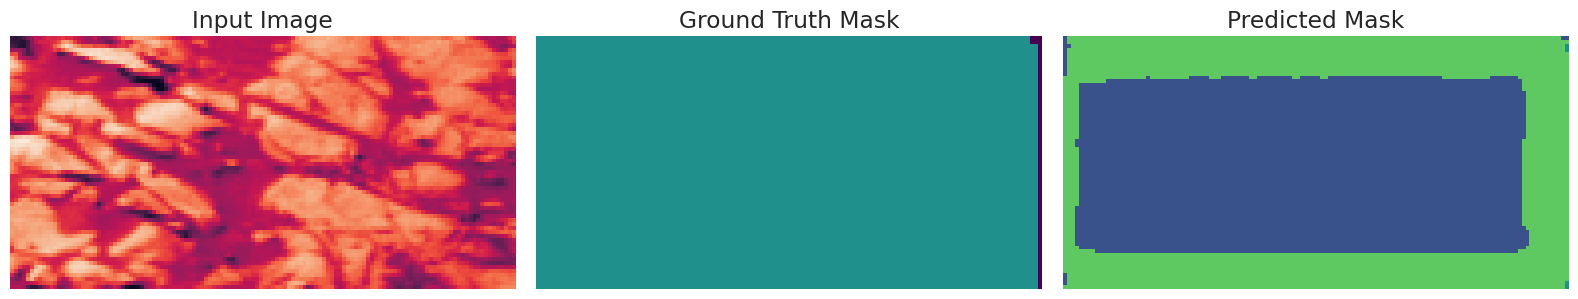

126/126 ━━━━━━━━━━━━━━━━━━━━ 119s 549ms/step - accuracy: 0.3371 - loss: 0.1569 - mean_iou: 0.1966 - val_accuracy: 0.2889 - val_loss: 0.4146 - val_mean_iou: 0.1359
Epoch 2/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.4070 - loss: 0.1073 - mean_iou: 0.3172 - val_accuracy: 0.1979 - val_loss: 0.3977 - val_mean_iou: 0.0657
Epoch 3/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.4549 - loss: 0.0779 - mean_iou: 0.3601 - val_accuracy: 0.1979 - val_loss: 0.4720 - val_mean_iou: 0.0657
Epoch 4/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.4520 - loss: 0.0855 - mean_iou: 0.3603 - val_accuracy: 0.2913 - val_loss: 0.2858 - val_mean_iou: 0.1595
Epoch 5/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.4478 - loss: 0.0790 - mean_iou: 0.3532 - val_accuracy: 0.4475 - val_loss: 0.1169 - val_mean_iou: 0.3455
Epoch 6/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5008 - loss: 0.0604 - mean_iou: 0.4134

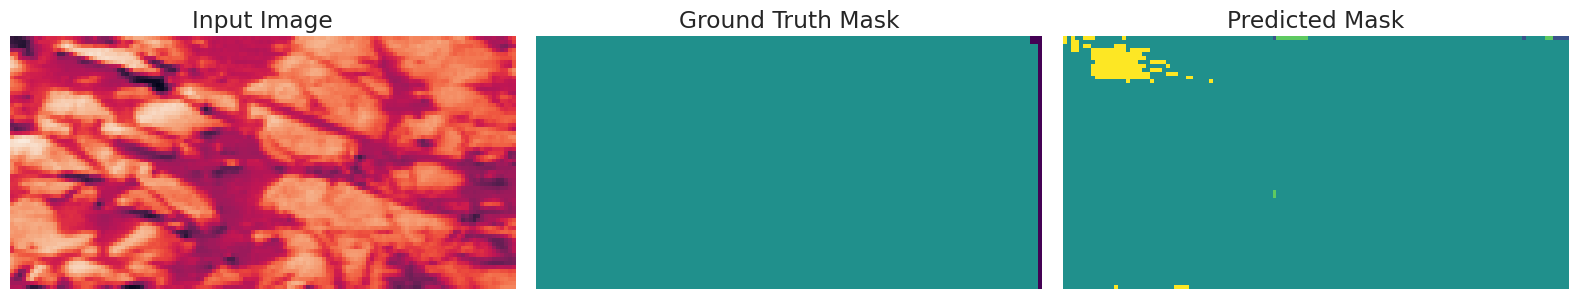

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 286ms/step - accuracy: 0.5009 - loss: 0.0604 - mean_iou: 0.4133 - val_accuracy: 0.4755 - val_loss: 0.1012 - val_mean_iou: 0.3624
Epoch 7/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.4966 - loss: 0.0567 - mean_iou: 0.4018 - val_accuracy: 0.5359 - val_loss: 0.0833 - val_mean_iou: 0.4338
Epoch 8/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.5212 - loss: 0.0535 - mean_iou: 0.4306 - val_accuracy: 0.5473 - val_loss: 0.0585 - val_mean_iou: 0.4436
Epoch 9/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.5223 - loss: 0.0583 - mean_iou: 0.4320 - val_accuracy: 0.5869 - val_loss: 0.0731 - val_mean_iou: 0.4970
Epoch 10/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.5393 - loss: 0.0446 - mean_iou: 0.4455 - val_accuracy: 0.5900 - val_loss: 0.0661 - val_mean_iou: 0.4968
Epoch 11/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5721 - loss: 0.0338 - mean_iou: 0.4954

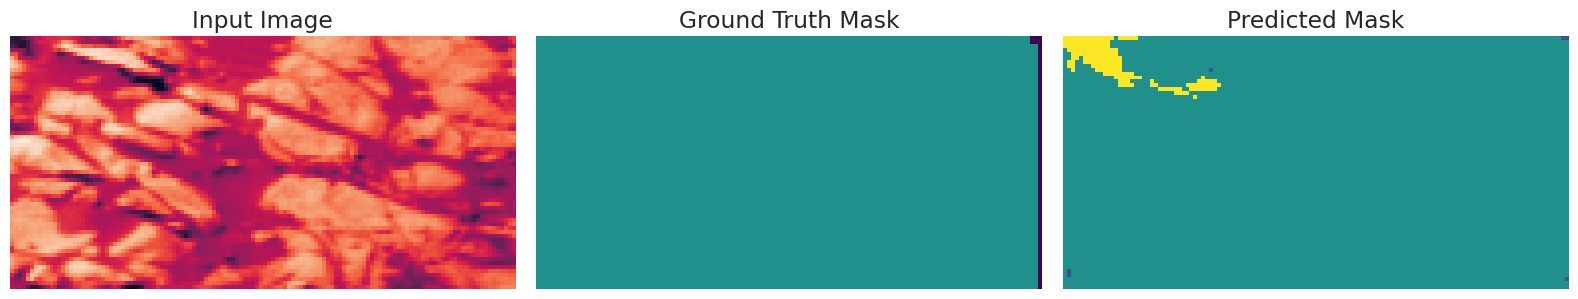

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 286ms/step - accuracy: 0.5721 - loss: 0.0338 - mean_iou: 0.4953 - val_accuracy: 0.5856 - val_loss: 0.0727 - val_mean_iou: 0.4932
Epoch 12/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.5444 - loss: 0.0442 - mean_iou: 0.4535 - val_accuracy: 0.1403 - val_loss: 0.3343 - val_mean_iou: 0.1346
Epoch 13/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.4819 - loss: 0.0729 - mean_iou: 0.3914 - val_accuracy: 0.3665 - val_loss: 0.1069 - val_mean_iou: 0.3011
Epoch 14/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.5387 - loss: 0.0493 - mean_iou: 0.4491 - val_accuracy: 0.5758 - val_loss: 0.0808 - val_mean_iou: 0.4734
Epoch 15/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.5430 - loss: 0.0539 - mean_iou: 0.4599 - val_accuracy: 0.5605 - val_loss: 0.0827 - val_mean_iou: 0.4618
Epoch 16/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5450 - loss: 0.0428 - mean_iou: 0.4581

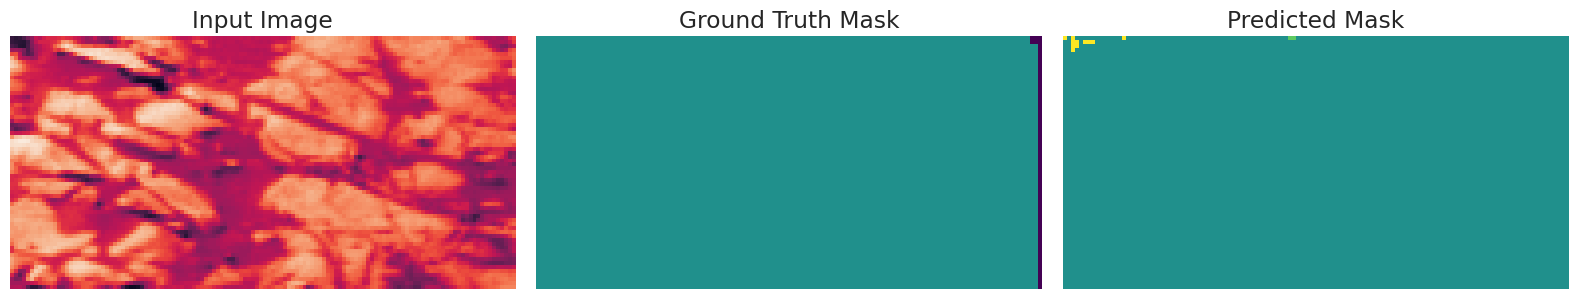

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 287ms/step - accuracy: 0.5451 - loss: 0.0427 - mean_iou: 0.4582 - val_accuracy: 0.5260 - val_loss: 0.1108 - val_mean_iou: 0.4030
Epoch 17/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 283ms/step - accuracy: 0.5709 - loss: 0.0352 - mean_iou: 0.4875 - val_accuracy: 0.5927 - val_loss: 0.1002 - val_mean_iou: 0.5124
Epoch 18/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.5983 - loss: 0.0292 - mean_iou: 0.5328 - val_accuracy: 0.6153 - val_loss: 0.0775 - val_mean_iou: 0.5475
Epoch 19/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.5628 - loss: 0.0401 - mean_iou: 0.4757 - val_accuracy: 0.5968 - val_loss: 0.0612 - val_mean_iou: 0.5087
Epoch 20/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.5967 - loss: 0.0282 - mean_iou: 0.5324 - val_accuracy: 0.5849 - val_loss: 0.0954 - val_mean_iou: 0.4905
Epoch 21/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6066 - loss: 0.0264 - mean_iou: 0.5501

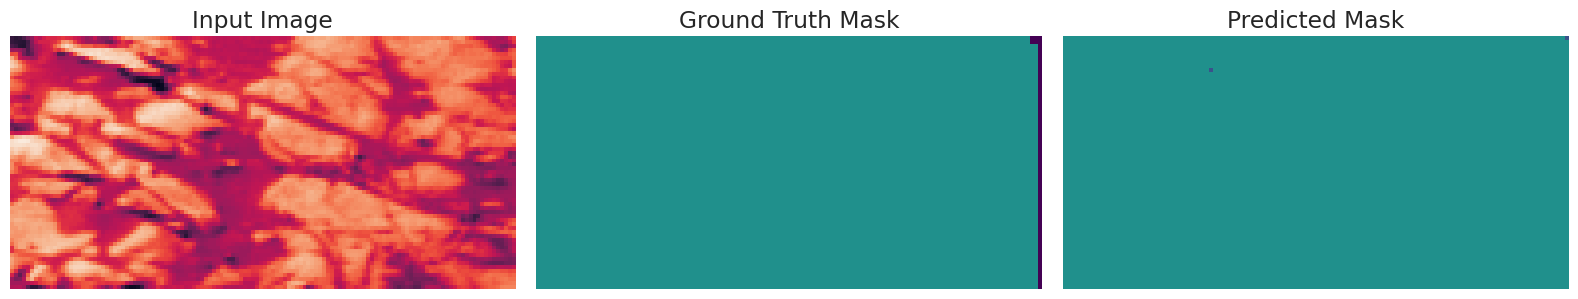

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 286ms/step - accuracy: 0.6066 - loss: 0.0264 - mean_iou: 0.5501 - val_accuracy: 0.6097 - val_loss: 0.1142 - val_mean_iou: 0.5574
Epoch 22/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 283ms/step - accuracy: 0.6096 - loss: 0.0245 - mean_iou: 0.5844 - val_accuracy: 0.6234 - val_loss: 0.0920 - val_mean_iou: 0.5542
Epoch 23/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.6258 - loss: 0.0217 - mean_iou: 0.6190 - val_accuracy: 0.5869 - val_loss: 0.1138 - val_mean_iou: 0.4965
Epoch 24/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.6179 - loss: 0.0224 - mean_iou: 0.6223 - val_accuracy: 0.6071 - val_loss: 0.1447 - val_mean_iou: 0.5387
Epoch 25/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.6155 - loss: 0.0228 - mean_iou: 0.6193 - val_accuracy: 0.6326 - val_loss: 0.1365 - val_mean_iou: 0.5958
Epoch 26/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6297 - loss: 0.0200 - mean_iou: 0.6481

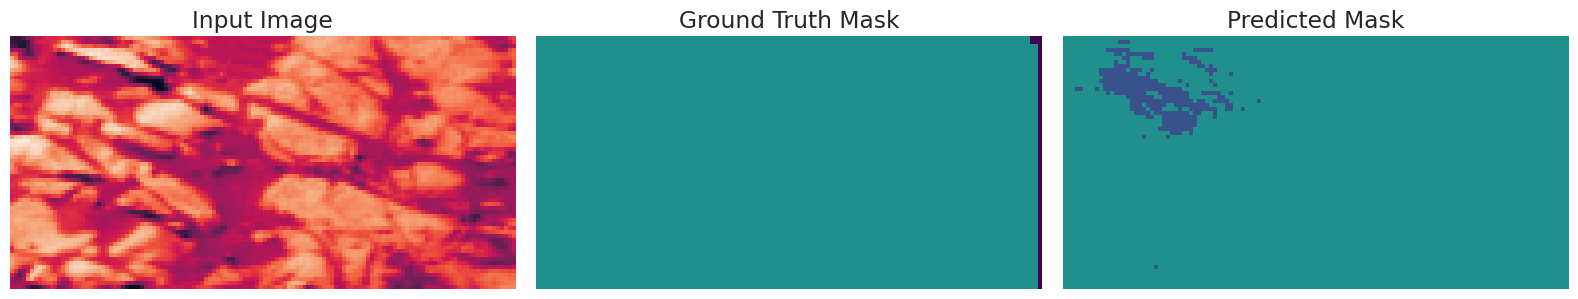

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 290ms/step - accuracy: 0.6298 - loss: 0.0200 - mean_iou: 0.6482 - val_accuracy: 0.5940 - val_loss: 0.1153 - val_mean_iou: 0.5293
Epoch 27/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 283ms/step - accuracy: 0.6371 - loss: 0.0187 - mean_iou: 0.6997 - val_accuracy: 0.5171 - val_loss: 0.1039 - val_mean_iou: 0.3868
Epoch 28/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 283ms/step - accuracy: 0.6254 - loss: 0.0215 - mean_iou: 0.5981 - val_accuracy: 0.6148 - val_loss: 0.1465 - val_mean_iou: 0.5369
Epoch 29/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.6354 - loss: 0.0194 - mean_iou: 0.6492 - val_accuracy: 0.6218 - val_loss: 0.1910 - val_mean_iou: 0.5255
Epoch 30/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 283ms/step - accuracy: 0.6490 - loss: 0.0167 - mean_iou: 0.6987 - val_accuracy: 0.5338 - val_loss: 0.1040 - val_mean_iou: 0.4073
Epoch 31/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5294 - loss: 0.0661 - mean_iou: 0.4356

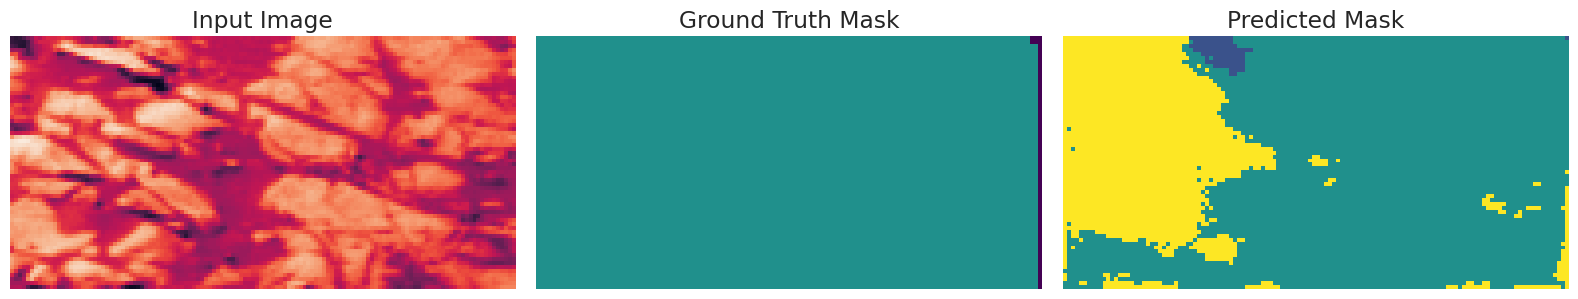

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 286ms/step - accuracy: 0.5293 - loss: 0.0662 - mean_iou: 0.4355 - val_accuracy: 0.4881 - val_loss: 0.0991 - val_mean_iou: 0.3732
Epoch 32/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.5514 - loss: 0.0491 - mean_iou: 0.4624 - val_accuracy: 0.5297 - val_loss: 0.0829 - val_mean_iou: 0.4095
Epoch 33/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.5296 - loss: 0.0694 - mean_iou: 0.4552 - val_accuracy: 0.5581 - val_loss: 0.0593 - val_mean_iou: 0.4641
Epoch 34/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.5647 - loss: 0.0395 - mean_iou: 0.4789 - val_accuracy: 0.6129 - val_loss: 0.1178 - val_mean_iou: 0.5570
Epoch 35/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6112 - loss: 0.0275 - mean_iou: 0.5476 - val_accuracy: 0.5943 - val_loss: 0.1399 - val_mean_iou: 0.5355
Epoch 36/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6290 - loss: 0.0215 - mean_iou: 0.6111

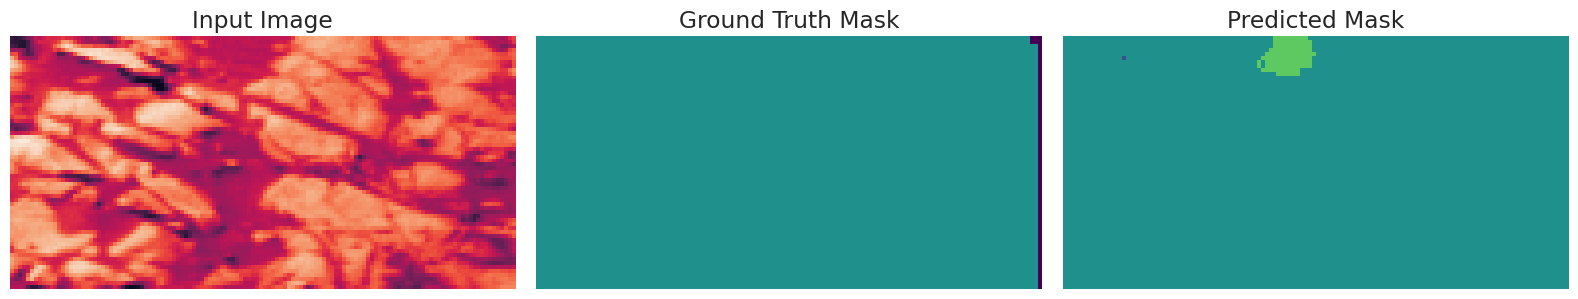

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - accuracy: 0.6290 - loss: 0.0215 - mean_iou: 0.6111 - val_accuracy: 0.6237 - val_loss: 0.1103 - val_mean_iou: 0.5733
Epoch 37/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6372 - loss: 0.0203 - mean_iou: 0.6399 - val_accuracy: 0.6137 - val_loss: 0.1142 - val_mean_iou: 0.5374
Epoch 38/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6351 - loss: 0.0194 - mean_iou: 0.6429 - val_accuracy: 0.5878 - val_loss: 0.1465 - val_mean_iou: 0.5278
Epoch 39/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6344 - loss: 0.0198 - mean_iou: 0.6249 - val_accuracy: 0.6252 - val_loss: 0.1517 - val_mean_iou: 0.5784
Epoch 40/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.6536 - loss: 0.0151 - mean_iou: 0.7406 - val_accuracy: 0.6460 - val_loss: 0.1590 - val_mean_iou: 0.6078
Epoch 41/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6512 - loss: 0.0142 - mean_iou: 0.7391

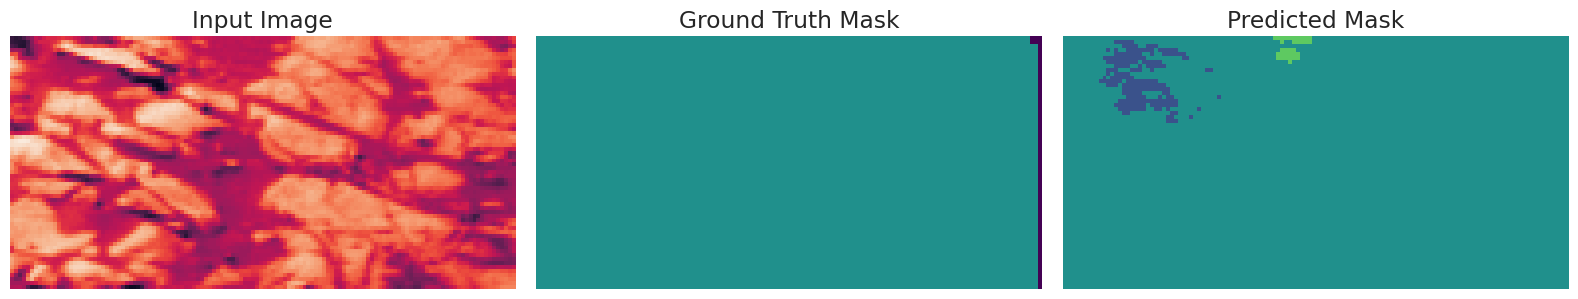

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 286ms/step - accuracy: 0.6513 - loss: 0.0142 - mean_iou: 0.7391 - val_accuracy: 0.5971 - val_loss: 0.1755 - val_mean_iou: 0.5179
Epoch 42/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6649 - loss: 0.0132 - mean_iou: 0.7435 - val_accuracy: 0.6445 - val_loss: 0.1220 - val_mean_iou: 0.6042
Epoch 43/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.6697 - loss: 0.0121 - mean_iou: 0.7661 - val_accuracy: 0.6095 - val_loss: 0.1303 - val_mean_iou: 0.5444
Epoch 44/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6754 - loss: 0.0116 - mean_iou: 0.8002 - val_accuracy: 0.6250 - val_loss: 0.1559 - val_mean_iou: 0.5903
Epoch 45/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6612 - loss: 0.0161 - mean_iou: 0.6945 - val_accuracy: 0.5692 - val_loss: 0.0904 - val_mean_iou: 0.4641
Epoch 46/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5576 - loss: 0.0531 - mean_iou: 0.4737

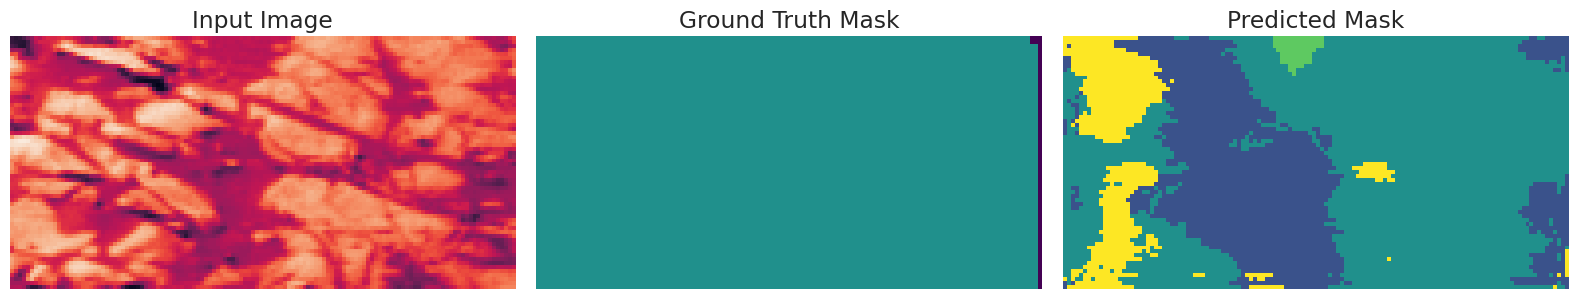

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - accuracy: 0.5577 - loss: 0.0531 - mean_iou: 0.4737 - val_accuracy: 0.5087 - val_loss: 0.1491 - val_mean_iou: 0.3720
Epoch 47/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6271 - loss: 0.0237 - mean_iou: 0.5696 - val_accuracy: 0.6242 - val_loss: 0.1345 - val_mean_iou: 0.5733
Epoch 48/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6536 - loss: 0.0164 - mean_iou: 0.6438 - val_accuracy: 0.6374 - val_loss: 0.1134 - val_mean_iou: 0.5938
Epoch 49/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6792 - loss: 0.0111 - mean_iou: 0.7214 - val_accuracy: 0.6177 - val_loss: 0.1489 - val_mean_iou: 0.5579
Epoch 50/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6825 - loss: 0.0107 - mean_iou: 0.7758 - val_accuracy: 0.5441 - val_loss: 0.1964 - val_mean_iou: 0.4565
Epoch 51/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6831 - loss: 0.0102 - mean_iou: 0.8048

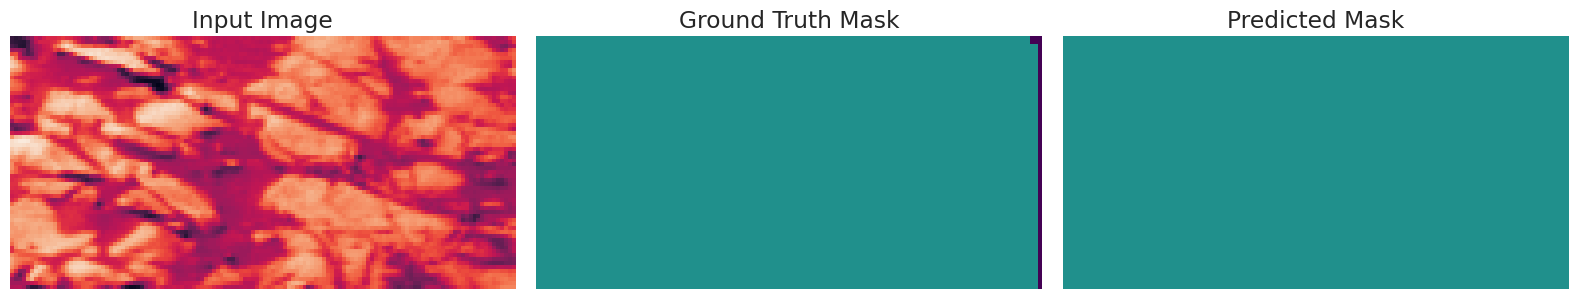

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - accuracy: 0.6832 - loss: 0.0102 - mean_iou: 0.8042 - val_accuracy: 0.6391 - val_loss: 0.1195 - val_mean_iou: 0.5819
Epoch 52/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6271 - loss: 0.0238 - mean_iou: 0.6002 - val_accuracy: 0.6198 - val_loss: 0.1172 - val_mean_iou: 0.5739
Epoch 53/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.6770 - loss: 0.0109 - mean_iou: 0.7593 - val_accuracy: 0.6114 - val_loss: 0.1769 - val_mean_iou: 0.5586
Epoch 54/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7024 - loss: 0.0072 - mean_iou: 0.8418 - val_accuracy: 0.6342 - val_loss: 0.1436 - val_mean_iou: 0.5973
Epoch 55/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6877 - loss: 0.0107 - mean_iou: 0.8013 - val_accuracy: 0.6091 - val_loss: 0.1810 - val_mean_iou: 0.5531
Epoch 56/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6950 - loss: 0.0084 - mean_iou: 0.8398

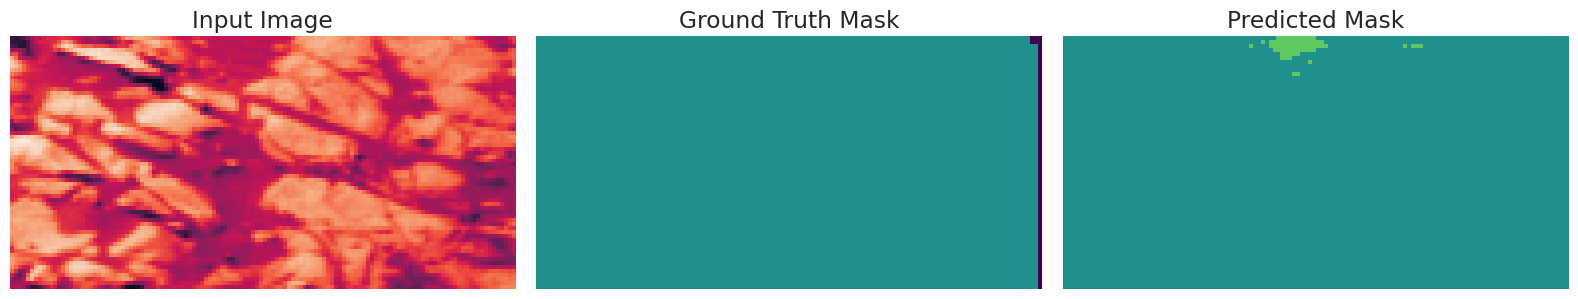

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 286ms/step - accuracy: 0.6951 - loss: 0.0084 - mean_iou: 0.8399 - val_accuracy: 0.6502 - val_loss: 0.1945 - val_mean_iou: 0.6093
Epoch 57/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6995 - loss: 0.0071 - mean_iou: 0.8485 - val_accuracy: 0.6372 - val_loss: 0.2001 - val_mean_iou: 0.6058
Epoch 58/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6882 - loss: 0.0097 - mean_iou: 0.8406 - val_accuracy: 0.6210 - val_loss: 0.1619 - val_mean_iou: 0.5765
Epoch 59/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.7190 - loss: 0.0049 - mean_iou: 0.8913 - val_accuracy: 0.6575 - val_loss: 0.2038 - val_mean_iou: 0.6327
Epoch 60/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.7174 - loss: 0.0043 - mean_iou: 0.9064 - val_accuracy: 0.6441 - val_loss: 0.1980 - val_mean_iou: 0.6159
Epoch 61/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6749 - loss: 0.0121 - mean_iou: 0.7735

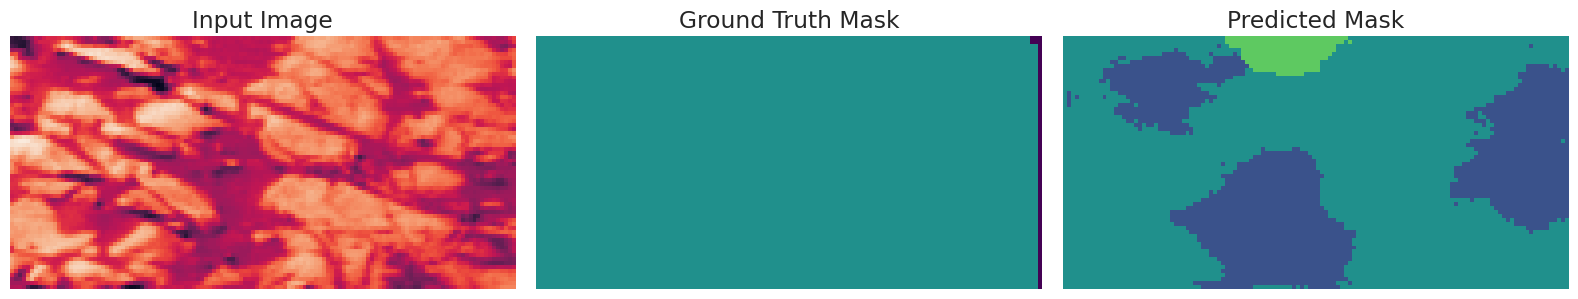

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - accuracy: 0.6751 - loss: 0.0121 - mean_iou: 0.7738 - val_accuracy: 0.5562 - val_loss: 0.2340 - val_mean_iou: 0.4724
Epoch 62/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7081 - loss: 0.0066 - mean_iou: 0.8808 - val_accuracy: 0.5239 - val_loss: 0.2678 - val_mean_iou: 0.4166
Epoch 63/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7152 - loss: 0.0049 - mean_iou: 0.8981 - val_accuracy: 0.6368 - val_loss: 0.2368 - val_mean_iou: 0.5839
Epoch 64/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7094 - loss: 0.0058 - mean_iou: 0.8877 - val_accuracy: 0.6616 - val_loss: 0.2293 - val_mean_iou: 0.6321
Epoch 65/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7245 - loss: 0.0035 - mean_iou: 0.9276 - val_accuracy: 0.4556 - val_loss: 0.4614 - val_mean_iou: 0.2876
Epoch 66/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5611 - loss: 0.0628 - mean_iou: 0.4828

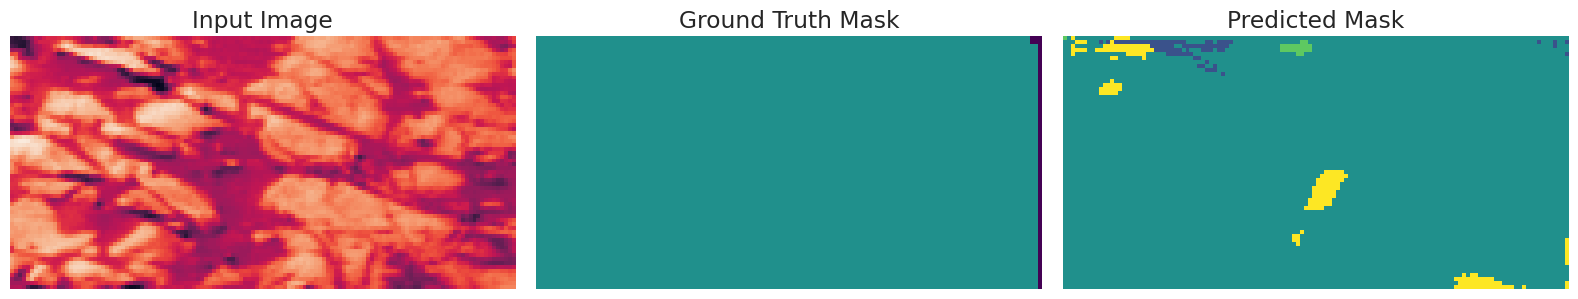

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - accuracy: 0.5611 - loss: 0.0628 - mean_iou: 0.4827 - val_accuracy: 0.5240 - val_loss: 0.0791 - val_mean_iou: 0.4169
Epoch 67/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.5997 - loss: 0.0320 - mean_iou: 0.5327 - val_accuracy: 0.6052 - val_loss: 0.1249 - val_mean_iou: 0.5395
Epoch 68/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6674 - loss: 0.0151 - mean_iou: 0.6424 - val_accuracy: 0.6241 - val_loss: 0.1732 - val_mean_iou: 0.5547
Epoch 69/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6893 - loss: 0.0098 - mean_iou: 0.7269 - val_accuracy: 0.6597 - val_loss: 0.1695 - val_mean_iou: 0.6207
Epoch 70/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7016 - loss: 0.0072 - mean_iou: 0.7868 - val_accuracy: 0.5972 - val_loss: 0.1766 - val_mean_iou: 0.5032
Epoch 71/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6967 - loss: 0.0104 - mean_iou: 0.7271

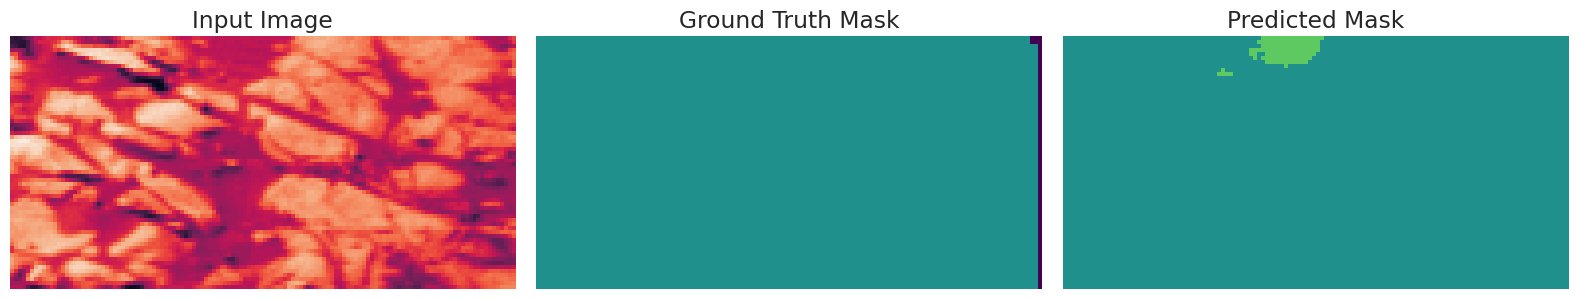

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - accuracy: 0.6968 - loss: 0.0104 - mean_iou: 0.7275 - val_accuracy: 0.6410 - val_loss: 0.1896 - val_mean_iou: 0.5986
Epoch 72/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7195 - loss: 0.0044 - mean_iou: 0.8809 - val_accuracy: 0.6480 - val_loss: 0.1722 - val_mean_iou: 0.6292
Epoch 73/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7241 - loss: 0.0035 - mean_iou: 0.8704 - val_accuracy: 0.6598 - val_loss: 0.1866 - val_mean_iou: 0.6385
Epoch 74/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7284 - loss: 0.0031 - mean_iou: 0.9091 - val_accuracy: 0.6300 - val_loss: 0.1963 - val_mean_iou: 0.5915
Epoch 75/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6676 - loss: 0.0163 - mean_iou: 0.7525 - val_accuracy: 0.5369 - val_loss: 0.2250 - val_mean_iou: 0.4220
Epoch 76/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7141 - loss: 0.0055 - mean_iou: 0.8248

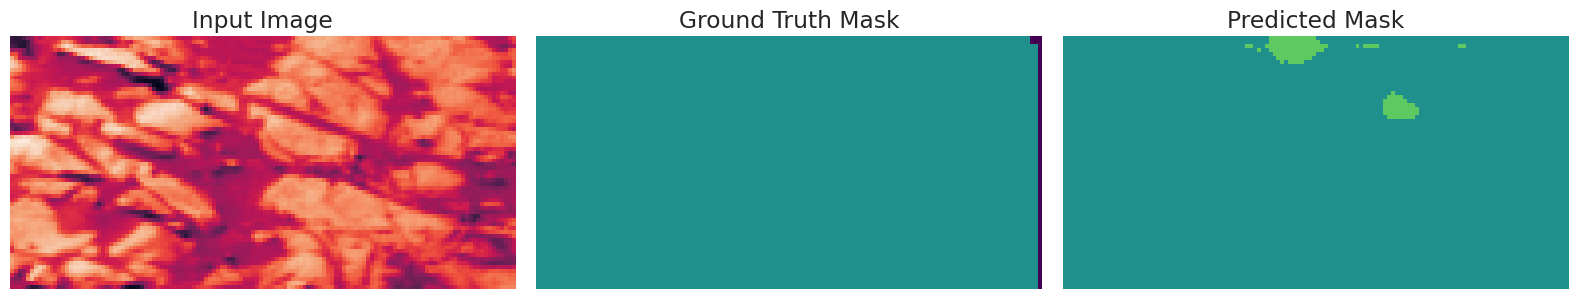

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - accuracy: 0.7143 - loss: 0.0055 - mean_iou: 0.8251 - val_accuracy: 0.5779 - val_loss: 0.2103 - val_mean_iou: 0.5303
Epoch 77/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7069 - loss: 0.0072 - mean_iou: 0.8653 - val_accuracy: 0.6521 - val_loss: 0.1620 - val_mean_iou: 0.6345
Epoch 78/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7141 - loss: 0.0052 - mean_iou: 0.8920 - val_accuracy: 0.6418 - val_loss: 0.1626 - val_mean_iou: 0.6201
Epoch 79/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7273 - loss: 0.0029 - mean_iou: 0.9102 - val_accuracy: 0.6563 - val_loss: 0.2040 - val_mean_iou: 0.6406
Epoch 80/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7349 - loss: 0.0020 - mean_iou: 0.9349 - val_accuracy: 0.6214 - val_loss: 0.2045 - val_mean_iou: 0.5738
Epoch 81/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7330 - loss: 0.0021 - mean_iou: 0.9347

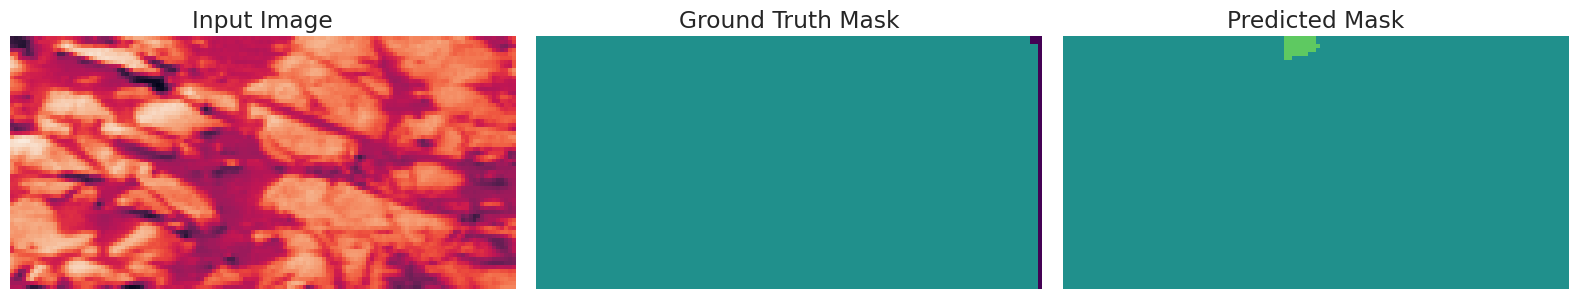

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - accuracy: 0.7331 - loss: 0.0021 - mean_iou: 0.9349 - val_accuracy: 0.6590 - val_loss: 0.1486 - val_mean_iou: 0.6307
Epoch 82/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7300 - loss: 0.0026 - mean_iou: 0.8919 - val_accuracy: 0.6467 - val_loss: 0.2265 - val_mean_iou: 0.6166
Epoch 83/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7356 - loss: 0.0018 - mean_iou: 0.9416 - val_accuracy: 0.6434 - val_loss: 0.2666 - val_mean_iou: 0.6137
Epoch 84/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7384 - loss: 0.0013 - mean_iou: 0.9612 - val_accuracy: 0.6584 - val_loss: 0.2037 - val_mean_iou: 0.6446
Epoch 85/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7329 - loss: 0.0018 - mean_iou: 0.9477 - val_accuracy: 0.6538 - val_loss: 0.2368 - val_mean_iou: 0.6311
Epoch 86/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7386 - loss: 0.0012 - mean_iou: 0.9746

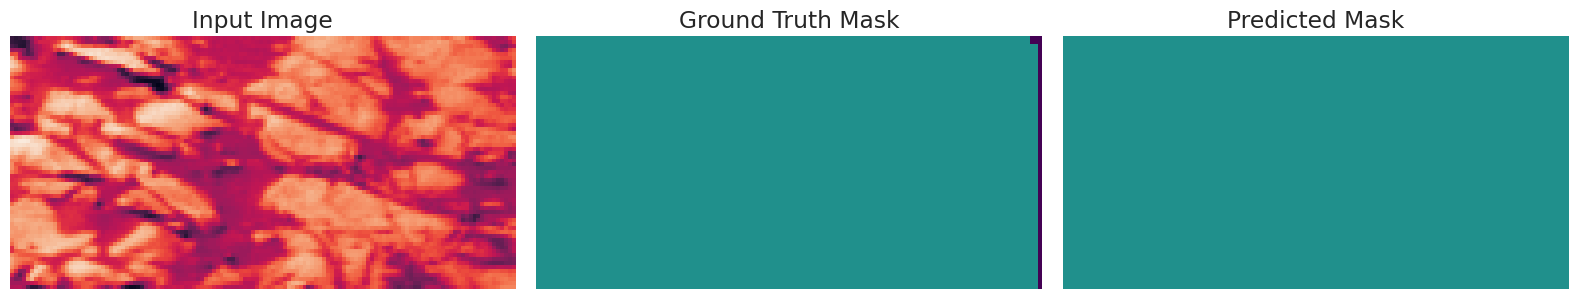

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - accuracy: 0.7387 - loss: 0.0012 - mean_iou: 0.9746 - val_accuracy: 0.6478 - val_loss: 0.2403 - val_mean_iou: 0.6325
Epoch 87/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7315 - loss: 0.0021 - mean_iou: 0.9602 - val_accuracy: 0.5840 - val_loss: 0.2433 - val_mean_iou: 0.5103
Epoch 88/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.5891 - loss: 0.0400 - mean_iou: 0.5439 - val_accuracy: 0.3387 - val_loss: 0.6373 - val_mean_iou: 0.2506
Epoch 89/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.5830 - loss: 0.0389 - mean_iou: 0.5047 - val_accuracy: 0.6184 - val_loss: 0.0966 - val_mean_iou: 0.5524
Epoch 90/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6803 - loss: 0.0129 - mean_iou: 0.6677 - val_accuracy: 0.5402 - val_loss: 0.1502 - val_mean_iou: 0.4862
Epoch 91/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7130 - loss: 0.0058 - mean_iou: 0.8034

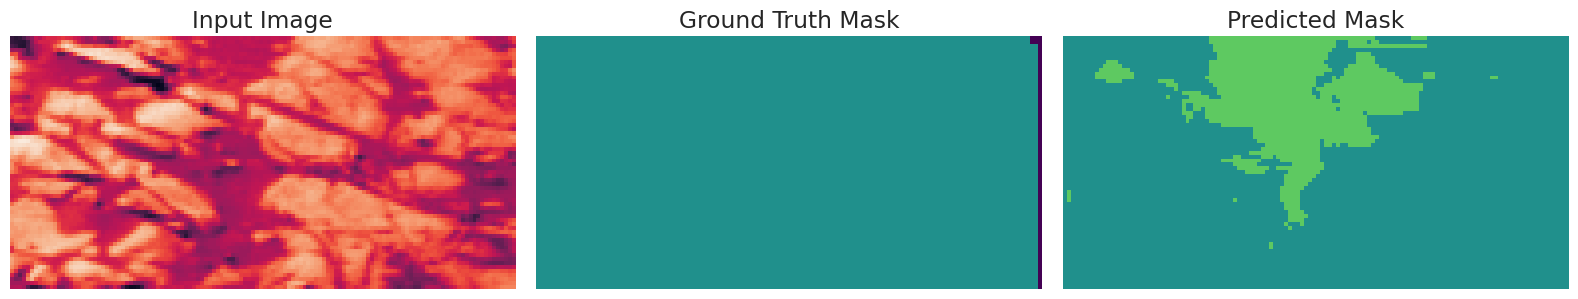

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - accuracy: 0.7131 - loss: 0.0058 - mean_iou: 0.8034 - val_accuracy: 0.6175 - val_loss: 0.1766 - val_mean_iou: 0.5533
Epoch 92/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6813 - loss: 0.0130 - mean_iou: 0.7366 - val_accuracy: 0.6154 - val_loss: 0.1811 - val_mean_iou: 0.5748
Epoch 93/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7230 - loss: 0.0044 - mean_iou: 0.8431 - val_accuracy: 0.6455 - val_loss: 0.1672 - val_mean_iou: 0.6094
Epoch 94/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7318 - loss: 0.0030 - mean_iou: 0.8466 - val_accuracy: 0.6581 - val_loss: 0.1381 - val_mean_iou: 0.6257
Epoch 95/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - accuracy: 0.7261 - loss: 0.0037 - mean_iou: 0.8937 - val_accuracy: 0.6597 - val_loss: 0.1683 - val_mean_iou: 0.6317
Epoch 96/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7339 - loss: 0.0019 - mean_iou: 0.9339

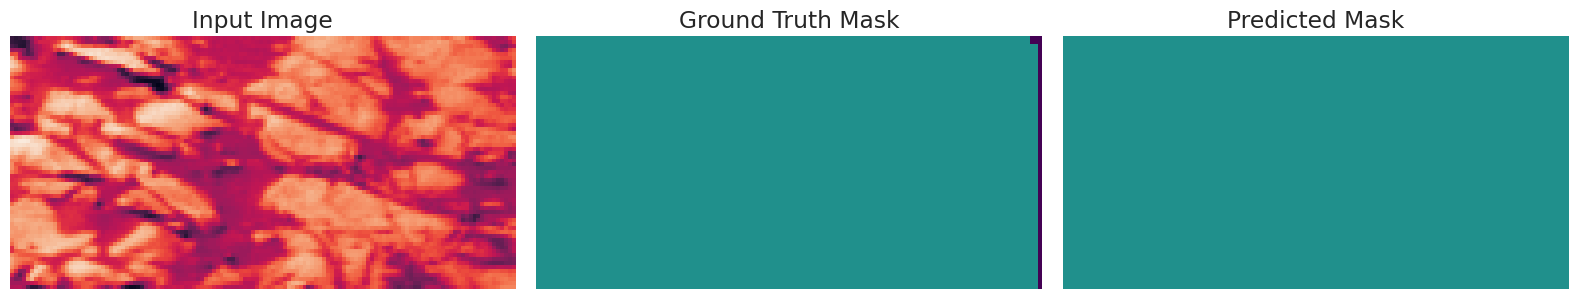

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - accuracy: 0.7340 - loss: 0.0019 - mean_iou: 0.9340 - val_accuracy: 0.6580 - val_loss: 0.1733 - val_mean_iou: 0.6313
Epoch 97/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - accuracy: 0.7369 - loss: 0.0014 - mean_iou: 0.9549 - val_accuracy: 0.6418 - val_loss: 0.2066 - val_mean_iou: 0.6089
Epoch 98/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7332 - loss: 0.0019 - mean_iou: 0.9431 - val_accuracy: 0.6243 - val_loss: 0.2029 - val_mean_iou: 0.5787
Epoch 99/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7354 - loss: 0.0018 - mean_iou: 0.9385 - val_accuracy: 0.6619 - val_loss: 0.1899 - val_mean_iou: 0.6384
Epoch 100/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7389 - loss: 0.0011 - mean_iou: 0.9532 - val_accuracy: 0.6331 - val_loss: 0.2131 - val_mean_iou: 0.5901
Epoch 101/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7222 - loss: 0.0036 - mean_iou: 0.9271

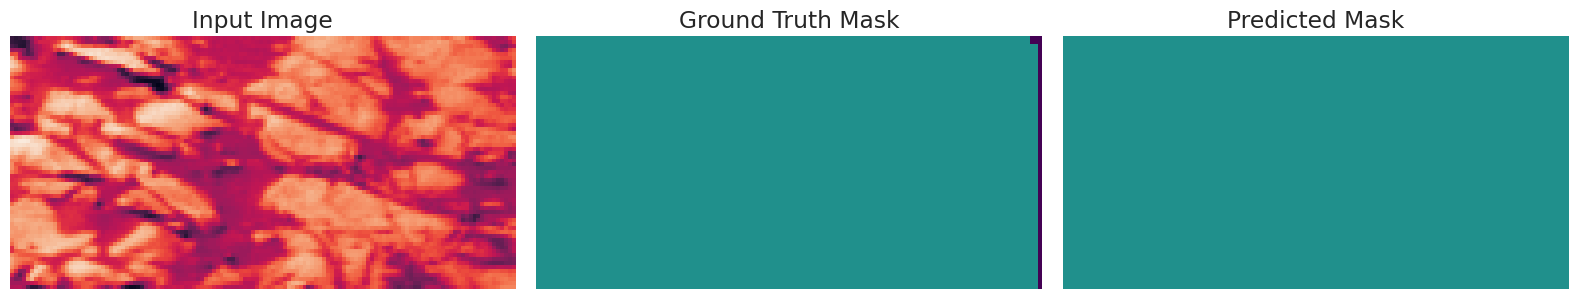

126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - accuracy: 0.7223 - loss: 0.0036 - mean_iou: 0.9273 - val_accuracy: 0.6634 - val_loss: 0.1769 - val_mean_iou: 0.6344
Epoch 102/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7360 - loss: 0.0014 - mean_iou: 0.9448 - val_accuracy: 0.6602 - val_loss: 0.2075 - val_mean_iou: 0.6343
Epoch 103/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7371 - loss: 0.0014 - mean_iou: 0.9563 - val_accuracy: 0.6613 - val_loss: 0.2084 - val_mean_iou: 0.6424
Epoch 104/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.7403 - loss: 8.6575e-04 - mean_iou: 0.9592 - val_accuracy: 0.6539 - val_loss: 0.2186 - val_mean_iou: 0.6361
Final validation Mean Intersection Over Union: 64.46%


In [20]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

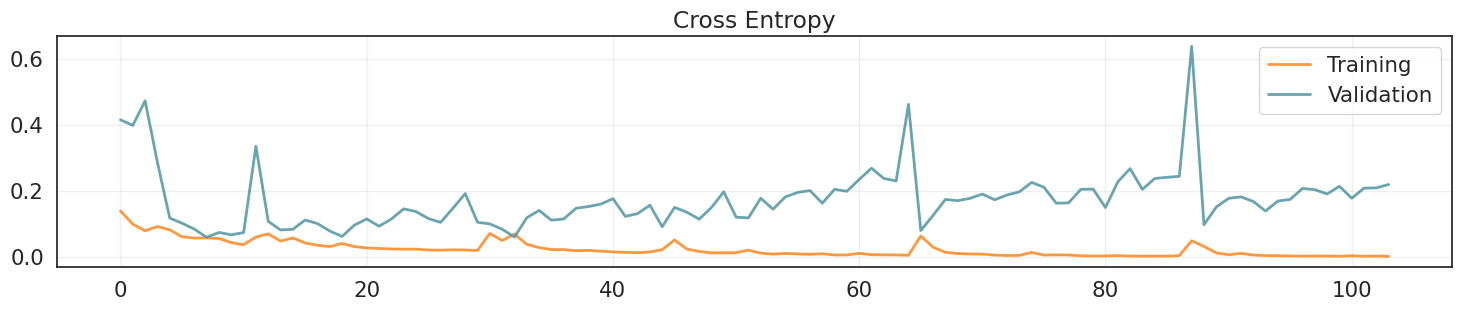

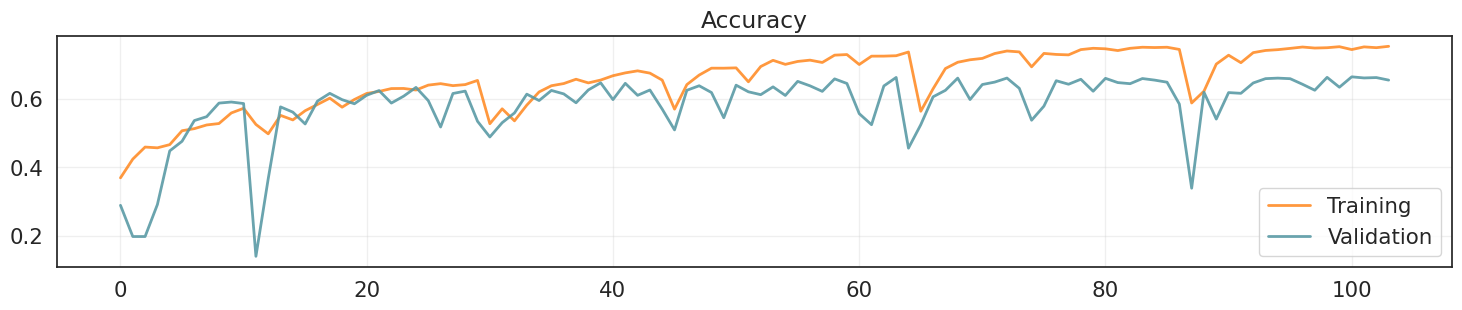

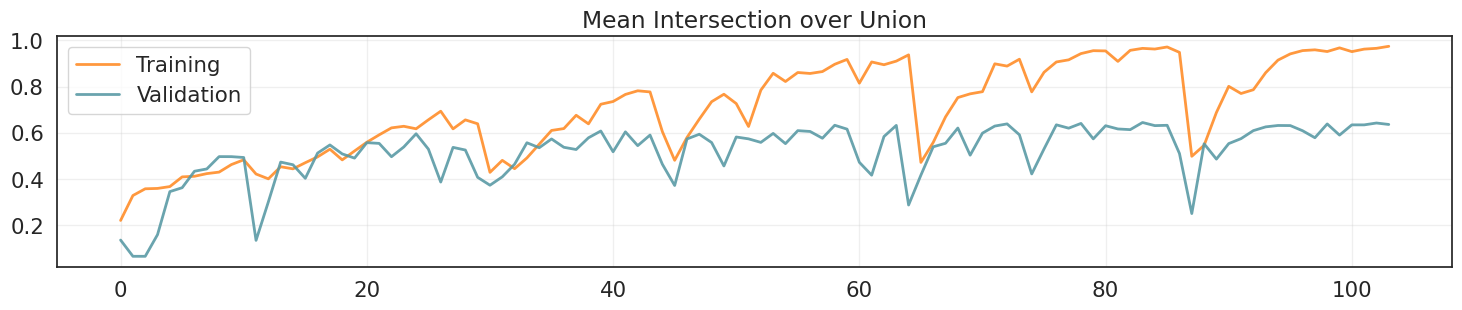

In [21]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [22]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 90s 248ms/step
Predictions shape: (10022, 64, 128)


In [23]:
def y_to_df(y) -> pd.DataFrame:
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [24]:
submission_filename = f"notworkingDiceLrScheduleFocal.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)